<a href="https://colab.research.google.com/github/XtremeGood/Blotter/blob/master/Modsim_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

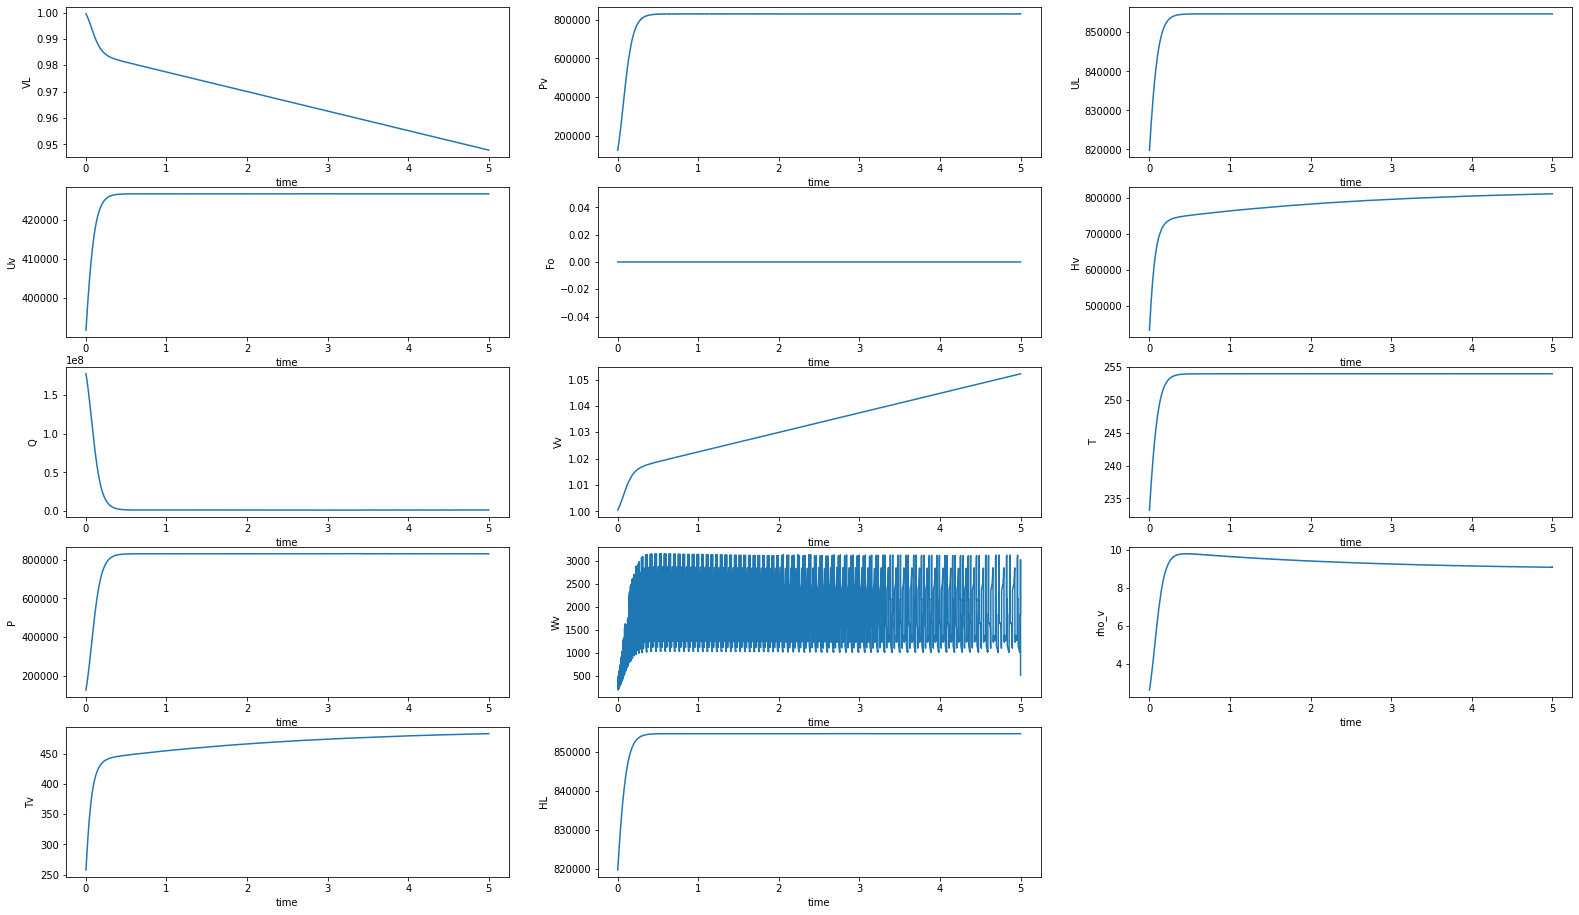

In [25]:
from random import random
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import RK45
from dataclasses import dataclass, InitVar, field, fields, asdict

# All values are put in SI units

@dataclass
class InstantaneousData():
    y: InitVar[np.ndarray]

    # liquid
    VL: float = field(init=False)
    Fo: float = field(init=False)
    T: float = field(init=False)
    P: float = field(init=False)
    HL: float = field(init=False)
    UL: float = field(init=False)
    Uv: float = field(init=False)

    # vapour
    Vv: float = field(init=False)
    rho_v: float = field(init=False)
    Tv: float = field(init=False)
    Pv: float = field(init=False)
    Hv: float = field(init=False)

    # others
    Q: float = field(init=False)
    Wv: float = field(init=False)

    def __post_init__(self, y):
        # liquid
        self.VL = y[0] / rho_o
        temp = Fo_steady + functions["devFo"](VL=self.VL)
        self.Fo = temp if temp >= 0 else 0
        self.T = y[1] / (self.VL * Cp * rho_o)
        self.P = functions["P"](T=self.T)
        self.HL = functions["HL"](T=self.T)
        self.UL = functions["HL"](T=self.T)
        self.Uv = functions["Uv"](T=self.T)

        # vapour
        self.Vv = V_chamber - self.VL
        self.rho_v = y[2] / self.Vv
        self.Tv = y[3] / (self.Vv * self.rho_v * Cp)
        self.Pv = functions["Pv"](rho_v=self.rho_v, T=self.Tv)
        self.Hv = Cp * self.Tv

        # others
        temp = Qo_steady + functions["devQ"](P=self.P)
        self.Q = temp if temp >= 0 else 0
        self.Wv = functions["Wv"](P=self.P, Pv=self.Pv)


def derivative(delta_t, y):
    assert y.ndim == 1, "Dimension is %s" % y.ndim
    data = InstantaneousData(y)

    return np.array(
        [
            rho_o * data.Fo - data.Wv,
            rho_o
            * data.Fo
            * ho
            - data.Wv * data.HL
            + data.Q,
            data.Wv - data.rho_v * Fv,
            data.Wv * data.HL
            - data.rho_v * Fv * data.Hv,
        ]
    )



# functions
functions = {
    "P": lambda T: 10 ** (A - B / (T + C)) * 100000,
    "Wv": lambda P, Pv: Km * (P - Pv),
    "Pv": lambda rho_v, T: (rho_v * R * T) / M,
    "devQ": lambda P: KQ * (Pset - P),
    "devFo": lambda VL: KFo * (VLset - VL),
    "HL": lambda T: latent_heat + T * Cp,
    "UL": lambda T: T * Cp,
    "Uv": lambda T: T * Cp,
}


###################################################
###################################################
###################################################

# RK 45 parameters
t_bound = 5

# Set Points
Pset = 836 * 1000  # Pa
VLset = 0.2  # m^3

# thermodynamic constants
R = 8.314  # J⋅ /K⋅ /mol

# Chamber properties
V_chamber = 2  # m^3

# Compound properties
Cp = 1.68 * 1000  # J / kg  / K
M = 44.1 / 1000  # kg / mol
Km = 1.71  # mol / s / Pa
latent_heat = 428 * 1000  # J / kg

# Antoine Equation
# Source: http://webserver.dmt.upm.es/~isidoro/dat1/ePv.pdf
A = 9.10
B = 1872  # K
C = -25.16  # K

# Proportality Constants of controllers
KQ = 250  # m^3
KFo = 200  # s^-1

# Inlet
rho_o = 493  # kg / m^ 3
To = 233.15  # K
ho = Cp * To

# Outlet
Fv = 0.4  # m^3/s

# Steady state values
Qo_steady = 67000  # J
Fo_steady = 1.111111  # m^3/s


# t  = 0 , intial values of variables
VL = 0.5 * V_chamber  # m^3
Vv = V_chamber - VL
rho_v = 2.356  # kg / m^3  https://www.engineeringtoolbox.com/propane-C3H8-density-specific-weight-temperature-pressure-d_2033.html
rho_o_VL = rho_o * VL
rho_VL_Cp_T = rho_o * VL * Cp * To
Vv_rho_v = Vv * rho_v
rho_v_Vv_Cp_T = rho_v * Vv * Cp * To


#############
def fill_dataframe(output):
    while output.status == "running":
        for i in range(50):
            if output.status == "running":
                output.step()
            else:
                break
        temp = {
            "time": output.t,
            **asdict(InstantaneousData(output.y)),

        }

        yield temp


output = RK45(
    fun=derivative,
    t0=0,
    y0=np.array([rho_o_VL, rho_VL_Cp_T, Vv_rho_v, rho_v_Vv_Cp_T]),
    t_bound=t_bound,
)

df = pd.DataFrame(data=[*fill_dataframe(output)])

ncols = 3
nrows = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(27, 16))

for i, v in enumerate(list(df.columns)[1:]):
    ax[i % nrows, i % ncols].plot(df["time"], df[v])
    ax[i % nrows, i % ncols].set_xlabel("time")
    ax[i % nrows, i % ncols].set_ylabel(v)
fig.delaxes(ax[nrows - 1][ncols - 1])
##plt.savefig(fr'imgs\{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')

In [26]:
df.VL.describe()

count    6561.000000
mean        0.966580
std         0.011239
min         0.947811
25%         0.957074
50%         0.966299
75%         0.975486
max         0.999491
Name: VL, dtype: float64

In [27]:
df.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>time</th>\n      <th>VL</th>\n      <th>Fo</th>\n      <th>T</th>\n      <th>P</th>\n      <th>HL</th>\n      <th>UL</th>\n      <th>Uv</th>\n      <th>Vv</th>\n      <th>rho_v</th>\n      <th>Tv</th>\n      <th>Pv</th>\n      <th>Hv</th>\n      <th>Q</th>\n      <th>Wv</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>0.000950</td>\n      <td>0.999491</td>\n      <td>0</td>\n      <td>233.224103</td>\n      <td>126698.891636</td>\n      <td>819816.492369</td>\n      <td>819816.492369</td>\n      <td>391816.492369</td>\n      <td>1.000509</td>\n      <td>2.604858</td>\n      <td>257.687097</td>\n      <td>126545.941582</td>\n      <td>432914.323435</td>\n      <td>1.773923e+08</td>\n      <td>261.544593</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>0.001936</td>\n      <td>0.999436</td>\n      <td>0</td>\n      <td>233.421103</td>\n     